# Notebook 1: Preparación de Datos (Versión Mejorada)

**Proyecto:** Entrega Final - Optimización de Estrategias de Retención

**Autores:** Juan David Valencia, Juan Esteban Cuellar

**Fecha:** Noviembre 2025

---

## Objetivo

Este notebook implementa el **pipeline de preparación de datos** con un enfoque en features interpretables y sin data leakage.

### Mejoras respecto a versión anterior:
1. **Features normalizados** en lugar de conteos crudos (elimina correlación con volumen)
2. **Índices de diversidad** tipo Shannon para categorías y tiendas
3. **Features de negocio** binarios (is_multi_category, is_multi_shop)
4. **Reducción a 10-15 features estrella** interpretables
5. **Documentación clara** del umbral de high_growth

**Entrada:** `dataset_protegido (1).csv` (41,667 usuarios × 15 variables)

**Salida:** 
- `data/processed/train.csv` (60%)
- `data/processed/val.csv` (20%)
- `data/processed/test.csv` (20%)

---

## 1. Setup y Configuración Global

In [2]:
# =============================================================================
# CONFIGURACIÓN GLOBAL Y CONSTANTES DE NEGOCIO
# =============================================================================
# Estas constantes definen umbrales clave del modelo y deben ser ajustadas
# según las necesidades del negocio.

# UMBRAL DE ALTO CRECIMIENTO
# Un usuario se considera "high_growth" si delta_orders > HIGH_GROWTH_THRESHOLD
# El valor 8 corresponde aproximadamente al percentil 80 de la distribución,
# es decir, el top ~20% de usuarios con mayor crecimiento.
# Justificación de negocio: Usuarios con >8 órdenes adicionales representan
# el segmento más valioso para el equipo de Engagement.
HIGH_GROWTH_THRESHOLD = 8

# UMBRALES PARA FEATURES DE NEGOCIO
# is_multi_category = 1 si el usuario compra en >= MULTI_CATEGORY_THRESHOLD categorías
# Usuarios "multi-categoría" exploran más el catálogo y tienen mayor potencial de cross-sell
MULTI_CATEGORY_THRESHOLD = 3

# is_multi_shop = 1 si el usuario compra en >= MULTI_SHOP_THRESHOLD tiendas
# Usuarios "multi-tienda" son menos fieles pero más activos; representan oportunidad de fidelización
MULTI_SHOP_THRESHOLD = 5

# SPLIT DE DATOS
TRAIN_SIZE = 0.60
VAL_SIZE = 0.20
TEST_SIZE = 0.20
RANDOM_SEED = 42

print("="*70)
print("CONFIGURACIÓN DEL PIPELINE DE PREPARACIÓN DE DATOS")
print("="*70)
print(f"\n📊 Umbral high_growth: delta_orders > {HIGH_GROWTH_THRESHOLD}")
print(f"   → Corresponde al top ~{100*(1-0.80):.0f}% de usuarios con mayor crecimiento")
print(f"\n🏪 Umbral multi-categoría: >= {MULTI_CATEGORY_THRESHOLD} categorías")
print(f"🛒 Umbral multi-tienda: >= {MULTI_SHOP_THRESHOLD} tiendas")
print(f"\n📂 Split de datos: Train {TRAIN_SIZE*100:.0f}% / Val {VAL_SIZE*100:.0f}% / Test {TEST_SIZE*100:.0f}%")
print(f"🎲 Random seed: {RANDOM_SEED}")
print("="*70)

CONFIGURACIÓN DEL PIPELINE DE PREPARACIÓN DE DATOS

📊 Umbral high_growth: delta_orders > 8
   → Corresponde al top ~20% de usuarios con mayor crecimiento

🏪 Umbral multi-categoría: >= 3 categorías
🛒 Umbral multi-tienda: >= 5 tiendas

📂 Split de datos: Train 60% / Val 20% / Test 20%
🎲 Random seed: 42


In [3]:
# =============================================================================
# IMPORTS
# =============================================================================
import pandas as pd
import numpy as np
import ast
import pickle
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
np.random.seed(RANDOM_SEED)

print("✅ Imports completados")
print(f"📅 Fecha de ejecución: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Imports completados
📅 Fecha de ejecución: 2025-11-29 20:18:51


In [4]:
# =============================================================================
# CARGA DE DATOS
# =============================================================================
DATASET_PATH = '../dataset_protegido (1).csv'

print(f"📂 Cargando dataset desde: {DATASET_PATH}")
df = pd.read_csv(DATASET_PATH)

print(f"✅ Dataset cargado: {df.shape[0]:,} filas × {df.shape[1]} columnas")
print(f"\n📊 Columnas originales:")
for i, col in enumerate(df.columns, 1):
    print(f"   {i:2d}. {col}")

df.head(3)

📂 Cargando dataset desde: ../dataset_protegido (1).csv
✅ Dataset cargado: 41,667 filas × 15 columnas

📊 Columnas originales:
    1. country_code
    2. uid
    3. total_orders
    4. total_orders_tmenos1
    5. delta_orders
    6. categoria_recencia
    7. first_order_date
    8. fourth_order_date
    9. efo_to_four
   10. main_category_counts
   11. ka_type_counts
   12. shop_name_counts
   13. brand_name_counts
   14. city_token
   15. r_segment


,country_code,uid,total_orders,total_orders_tmenos1,delta_orders,categoria_recencia,first_order_date,fourth_order_date,efo_to_four,main_category_counts,ka_type_counts,shop_name_counts,brand_name_counts,city_token,r_segment
0,CO,492892698476209,5,0,5,Frío (31–90d),2025-07-11,2025-07-19,8,"{'main_category007': 2, 'main_category021': 1,...","{'ka_type001': 2, 'ka_type003': 2, 'ka_type002...","{'shop_9847': 1, 'shop_7310': 1, 'shop_8864': ...","{'brand001': 3, 'brand641': 1, 'brand691': 1}",city002,r_segment001
1,CO,492892701117693,9,0,9,Tibio (15–30d),2025-08-18,2025-08-22,4,"{'main_category023': 1, 'main_category021': 5,...","{'ka_type001': 3, 'ka_type002': 6}","{'shop_334': 1, 'shop_10579': 1, 'shop_6584': ...","{'brand352': 1, 'brand458': 1, 'brand580': 1, ...",city001,r_segment002
2,CO,492892701156786,9,0,9,Frío (31–90d),2025-07-14,2025-07-16,2,"{'main_category007': 1, 'main_category021': 1,...","{'ka_type001': 4, 'ka_type003': 1, 'ka_type002...","{'shop_7148': 1, 'shop_5045': 2, 'shop_2485': ...","{'brand001': 1, 'brand352': 3, 'brand502': 1, ...",city001,r_segment001


## 2. Feature Engineering: Enfoque Interpretable

### Filosofía de diseño de features:

Evitamos usar conteos crudos (`num_categories`, `num_shops`, `num_brands`) porque están altamente correlacionados con el volumen de órdenes: a más órdenes, más variedad de compras. Esto genera multicolinealidad y dificulta la interpretación.

En su lugar, usamos:
1. **Features normalizados por orden**: `X_per_order = X / total_orders`
2. **Índices de diversidad**: Entropía de Shannon (mide qué tan dispersas son las compras)
3. **Features binarios de negocio**: Fáciles de explicar a stakeholders

### 2.1 Parsing de Columnas Diccionario

In [5]:
# =============================================================================
# PARSEO DE COLUMNAS DICCIONARIO
# =============================================================================
# Las columnas de afinidades están almacenadas como strings de diccionarios.
# Ejemplo: "{'main_category007': 2, 'main_category021': 1}"
# Necesitamos convertirlas a diccionarios de Python para extraer features.

dict_columns = ['main_category_counts', 'ka_type_counts', 'shop_name_counts', 'brand_name_counts']

print("🔧 Parseando columnas de diccionarios...\n")
for col in dict_columns:
    if col in df.columns:
        try:
            df[col] = df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
            print(f"  ✓ {col} parseado correctamente")
        except Exception as e:
            print(f"  ✗ Error parseando {col}: {str(e)}")

print("\n✅ Parseo completado")

# Verificar ejemplo
print(f"\n📄 Ejemplo de main_category_counts (usuario 0):")
print(f"   {df['main_category_counts'].iloc[0]}")

🔧 Parseando columnas de diccionarios...

  ✓ main_category_counts parseado correctamente
  ✓ ka_type_counts parseado correctamente
  ✓ shop_name_counts parseado correctamente
  ✓ brand_name_counts parseado correctamente

✅ Parseo completado

📄 Ejemplo de main_category_counts (usuario 0):
   {'main_category007': 2, 'main_category021': 1, 'main_category027': 1, 'main_category010': 1}


### 2.2 Funciones de Cálculo de Features

In [6]:
# =============================================================================
# FUNCIONES AUXILIARES PARA FEATURE ENGINEERING
# =============================================================================

def shannon_entropy(counts_dict):
    """
    Calcula el índice de Shannon (entropía) de un diccionario de conteos.
    
    La entropía de Shannon mide la "diversidad" o "dispersión" de las compras:
    - Entropía = 0: Usuario compra solo en 1 categoría/tienda (muy concentrado)
    - Entropía alta: Usuario distribuye compras uniformemente entre muchas opciones
    
    Interpretación de negocio:
    - Alta diversidad → Usuario explorador → Oportunidad de cross-sell
    - Baja diversidad → Usuario enfocado → Oportunidad de fidelización en su nicho
    
    Parámetros:
    -----------
    counts_dict : dict
        Diccionario {categoria: num_ordenes}
    
    Retorna:
    --------
    float : Índice de Shannon (0 a log(n) donde n es el número de categorías)
    """
    if not isinstance(counts_dict, dict) or len(counts_dict) == 0:
        return 0.0
    
    total = sum(counts_dict.values())
    if total == 0:
        return 0.0
    
    entropy = 0
    for count in counts_dict.values():
        if count > 0:
            p = count / total
            entropy -= p * np.log(p)
    
    return entropy


def get_dominant_item(counts_dict):
    """
    Retorna el item con mayor número de órdenes.
    
    Interpretación de negocio:
    - La categoría/tienda dominante indica la "afinidad principal" del usuario
    - Útil para personalizar incentivos (ej: cupón en categoría dominante)
    """
    if not isinstance(counts_dict, dict) or len(counts_dict) == 0:
        return 'unknown'
    return max(counts_dict, key=counts_dict.get)


def get_dominant_ratio(counts_dict):
    """
    Calcula el ratio de concentración en el item dominante.
    
    Interpretación de negocio:
    - Ratio alto (>0.7) → Usuario muy concentrado en 1 opción → Alta lealtad
    - Ratio bajo (<0.3) → Usuario diversificado → Menor lealtad, más exploración
    """
    if not isinstance(counts_dict, dict) or len(counts_dict) == 0:
        return 0.0
    
    total = sum(counts_dict.values())
    if total == 0:
        return 0.0
    
    max_count = max(counts_dict.values())
    return max_count / total


def get_brand001_ratio(brand_dict, total_orders):
    """
    Calcula el ratio de órdenes de brand001 (marca líder del mercado).
    
    Interpretación de negocio:
    - brand001 tiene ~40% del mercado según EDA
    - Ratio alto → Usuario mainstream → Responde bien a promociones de marca líder
    - Ratio bajo → Usuario de nicho → Prefiere marcas alternativas
    """
    if not isinstance(brand_dict, dict) or total_orders == 0:
        return 0.0
    return brand_dict.get('brand001', 0) / total_orders


print("✅ Funciones de feature engineering definidas")

✅ Funciones de feature engineering definidas


### 2.3 Creación de Features Normalizados y de Diversidad

In [7]:
# =============================================================================
# FEATURE ENGINEERING: DIVERSIDAD Y NORMALIZACIÓN
# =============================================================================

print("🔧 Creando features de diversidad y normalización...\n")

# -----------------------------------------------------------------------------
# 1. CONTEOS BASE (solo para cálculos intermedios, NO para el modelo final)
# -----------------------------------------------------------------------------
df['_num_categories'] = df['main_category_counts'].apply(lambda x: len(x) if isinstance(x, dict) else 0)
df['_num_shops'] = df['shop_name_counts'].apply(lambda x: len(x) if isinstance(x, dict) else 0)
df['_num_brands'] = df['brand_name_counts'].apply(lambda x: len(x) if isinstance(x, dict) else 0)
print("  ✓ Conteos base calculados (uso interno, no se incluirán en modelo)")

# -----------------------------------------------------------------------------
# 2. FEATURES NORMALIZADOS POR ORDEN
# Estos capturan "intensidad de exploración" independiente del volumen de órdenes
# -----------------------------------------------------------------------------

# Categorías por orden: ¿Cuántas categorías distintas usa en promedio por orden?
# Valor alto → Usuario que explora muchas categorías por orden
# Valor bajo → Usuario enfocado en pocas categorías
df['categories_per_order'] = df['_num_categories'] / df['total_orders']
print("  ✓ categories_per_order: diversidad de categorías normalizada por volumen")

# Tiendas por orden: ¿Cuántas tiendas distintas visita en promedio por orden?
# Valor alto → Usuario que distribuye órdenes entre muchas tiendas (baja lealtad)
# Valor bajo → Usuario concentrado en pocas tiendas (alta lealtad)
df['shops_per_order'] = df['_num_shops'] / df['total_orders']
print("  ✓ shops_per_order: diversidad de tiendas normalizada por volumen")

# -----------------------------------------------------------------------------
# 3. ÍNDICES DE DIVERSIDAD (Shannon)
# Miden qué tan dispersas están las compras entre opciones
# -----------------------------------------------------------------------------

# Diversidad de categorías: ¿Qué tan uniformes son sus compras entre categorías?
df['category_diversity'] = df['main_category_counts'].apply(shannon_entropy)
print("  ✓ category_diversity: índice de Shannon para categorías")

# Diversidad de tiendas: ¿Qué tan uniformes son sus compras entre tiendas?
df['shop_diversity'] = df['shop_name_counts'].apply(shannon_entropy)
print("  ✓ shop_diversity: índice de Shannon para tiendas")

# -----------------------------------------------------------------------------
# 4. RATIOS DE CONCENTRACIÓN
# Complementan la diversidad: miden qué tan concentrado está en su opción favorita
# -----------------------------------------------------------------------------

# Ratio de categoría dominante: % de órdenes en su categoría favorita
df['dominant_category_ratio'] = df['main_category_counts'].apply(get_dominant_ratio)
print("  ✓ dominant_category_ratio: concentración en categoría favorita")

# Ratio de brand001: % de órdenes de la marca líder (brand001 = 40% del mercado)
df['brand001_ratio'] = df.apply(lambda row: get_brand001_ratio(row['brand_name_counts'], row['total_orders']), axis=1)
print("  ✓ brand001_ratio: afinidad con marca líder del mercado")

print("\n✅ Features de diversidad y normalización creados")

🔧 Creando features de diversidad y normalización...

  ✓ Conteos base calculados (uso interno, no se incluirán en modelo)
  ✓ categories_per_order: diversidad de categorías normalizada por volumen
  ✓ shops_per_order: diversidad de tiendas normalizada por volumen
  ✓ category_diversity: índice de Shannon para categorías
  ✓ shop_diversity: índice de Shannon para tiendas
  ✓ dominant_category_ratio: concentración en categoría favorita
  ✓ brand001_ratio: afinidad con marca líder del mercado

✅ Features de diversidad y normalización creados


### 2.4 Features Binarios de Negocio

In [8]:
# =============================================================================
# FEATURES BINARIOS DE NEGOCIO
# =============================================================================
# Estos features son fáciles de explicar a stakeholders:
# "¿Es un usuario multi-categoría?" → Sí/No
# "¿Es un usuario multi-tienda?" → Sí/No

print("🔧 Creando features binarios de negocio...\n")

# is_multi_category: Usuario que compra en 3+ categorías distintas
# Interpretación: Usuario explorador del catálogo → Mayor potencial de cross-sell
df['is_multi_category'] = (df['_num_categories'] >= MULTI_CATEGORY_THRESHOLD).astype(int)
pct_multi_cat = df['is_multi_category'].mean() * 100
print(f"  ✓ is_multi_category: 1 si usa >={MULTI_CATEGORY_THRESHOLD} categorías ({pct_multi_cat:.1f}% de usuarios)")

# is_multi_shop: Usuario que compra en 5+ tiendas distintas
# Interpretación: Usuario que distribuye compras → Baja lealtad, alta actividad
df['is_multi_shop'] = (df['_num_shops'] >= MULTI_SHOP_THRESHOLD).astype(int)
pct_multi_shop = df['is_multi_shop'].mean() * 100
print(f"  ✓ is_multi_shop: 1 si usa >={MULTI_SHOP_THRESHOLD} tiendas ({pct_multi_shop:.1f}% de usuarios)")

print("\n✅ Features binarios de negocio creados")

🔧 Creando features binarios de negocio...

  ✓ is_multi_category: 1 si usa >=3 categorías (74.7% de usuarios)
  ✓ is_multi_shop: 1 si usa >=5 tiendas (50.8% de usuarios)

✅ Features binarios de negocio creados


### 2.5 Features Temporales y de Velocidad

In [9]:
# =============================================================================
# FEATURES TEMPORALES Y DE VELOCIDAD
# =============================================================================

print("🔧 Creando features temporales...\n")

# Convertir columnas de fecha a datetime
df['first_order_date'] = pd.to_datetime(df['first_order_date'])
df['fourth_order_date'] = pd.to_datetime(df['fourth_order_date'])

# Fecha de referencia para calcular recencia
# Usamos la fecha más reciente del dataset como "fecha de corte"
REFERENCE_DATE = df['first_order_date'].max()
print(f"  📅 Fecha de referencia (corte): {REFERENCE_DATE.strftime('%Y-%m-%d')}")

# -----------------------------------------------------------------------------
# efo_to_four: Días desde primera hasta cuarta orden
# Este es el feature MÁS IMPORTANTE según el EDA:
# - Adopción rápida (0-7 días): 9.5 órdenes promedio de crecimiento
# - Adopción lenta (>21 días): 4.1 órdenes promedio de crecimiento
# Diferencia de 2.3x entre adoptadores rápidos vs lentos
# -----------------------------------------------------------------------------
# Ya viene en el dataset como 'efo_to_four'
print(f"  ✓ efo_to_four: velocidad de adopción (ya existe en dataset)")
print(f"     Promedio: {df['efo_to_four'].mean():.1f} días | Mediana: {df['efo_to_four'].median():.0f} días")

# -----------------------------------------------------------------------------
# days_since_first_order: Antigüedad del usuario
# Usuarios más antiguos han tenido más tiempo para generar órdenes
# -----------------------------------------------------------------------------
df['days_since_first_order'] = (REFERENCE_DATE - df['first_order_date']).dt.days
print(f"  ✓ days_since_first_order: antigüedad del usuario")

print("\n✅ Features temporales creados")

🔧 Creando features temporales...

  📅 Fecha de referencia (corte): 2025-09-28
  ✓ efo_to_four: velocidad de adopción (ya existe en dataset)
     Promedio: 14.9 días | Mediana: 14 días
  ✓ days_since_first_order: antigüedad del usuario

✅ Features temporales creados


### 2.6 Features de Afinidad (Categoría y Tipo de Tienda)

In [10]:
# =============================================================================
# FEATURES DE AFINIDAD
# =============================================================================
# Capturan las preferencias principales del usuario

print("🔧 Creando features de afinidad...\n")

# Categoría dominante: La categoría donde más compra el usuario
df['dominant_category'] = df['main_category_counts'].apply(get_dominant_item)
print(f"  ✓ dominant_category: categoría con más órdenes del usuario")

# Tipo de tienda dominante (ka_type): El tipo de tienda donde más compra
df['dominant_ka_type'] = df['ka_type_counts'].apply(get_dominant_item)
print(f"  ✓ dominant_ka_type: tipo de tienda preferido")

# Ver distribución de categorías dominantes
print(f"\n📊 Top 5 categorías dominantes:")
top_cats = df['dominant_category'].value_counts().head(5)
for cat, count in top_cats.items():
    print(f"   {cat}: {count:,} usuarios ({count/len(df)*100:.1f}%)")

print("\n✅ Features de afinidad creados")

🔧 Creando features de afinidad...

  ✓ dominant_category: categoría con más órdenes del usuario
  ✓ dominant_ka_type: tipo de tienda preferido

📊 Top 5 categorías dominantes:
   main_category007: 9,844 usuarios (23.6%)
   main_category008: 7,505 usuarios (18.0%)
   main_category013: 6,348 usuarios (15.2%)
   main_category021: 4,502 usuarios (10.8%)
   main_category010: 3,286 usuarios (7.9%)

✅ Features de afinidad creados


### 2.7 Creación de Variable Objetivo (Target)

In [11]:
# =============================================================================
# VARIABLE OBJETIVO: high_growth
# =============================================================================

print("🎯 Creando variable objetivo...\n")

# high_growth: Variable binaria para clasificación
# 1 = Usuario de alto crecimiento (delta_orders > HIGH_GROWTH_THRESHOLD)
# 0 = Usuario de crecimiento normal/bajo
df['high_growth'] = (df['delta_orders'] > HIGH_GROWTH_THRESHOLD).astype(int)

print(f"  📌 Umbral HIGH_GROWTH_THRESHOLD = {HIGH_GROWTH_THRESHOLD}")
print(f"  📌 Definición: high_growth = 1 si delta_orders > {HIGH_GROWTH_THRESHOLD}")

# Calcular percentil real del umbral
percentil_real = (df['delta_orders'] <= HIGH_GROWTH_THRESHOLD).mean() * 100
print(f"\n  📊 El umbral {HIGH_GROWTH_THRESHOLD} corresponde al percentil {percentil_real:.1f}%")
print(f"     (Es decir, {100-percentil_real:.1f}% de usuarios son high_growth)")

# Distribución de la variable objetivo
print(f"\n📊 Distribución de high_growth:")
dist = df['high_growth'].value_counts()
print(f"   - No High-Growth (0): {dist[0]:,} usuarios ({dist[0]/len(df)*100:.1f}%)")
print(f"   - High-Growth (1): {dist[1]:,} usuarios ({dist[1]/len(df)*100:.1f}%)")

# Estadísticas de delta_orders por clase
print(f"\n📊 Estadísticas de delta_orders por clase:")
print(df.groupby('high_growth')['delta_orders'].describe()[['mean', 'std', 'min', 'max']])

print("\n✅ Variable objetivo creada")

🎯 Creando variable objetivo...

  📌 Umbral HIGH_GROWTH_THRESHOLD = 8
  📌 Definición: high_growth = 1 si delta_orders > 8

  📊 El umbral 8 corresponde al percentil 79.6%
     (Es decir, 20.4% de usuarios son high_growth)

📊 Distribución de high_growth:
   - No High-Growth (0): 33,184 usuarios (79.6%)
   - High-Growth (1): 8,483 usuarios (20.4%)

📊 Estadísticas de delta_orders por clase:
                  mean       std  min    max
high_growth                                 
0             5.057287  1.511432  1.0    8.0
1            13.879995  7.055694  9.0  108.0

✅ Variable objetivo creada


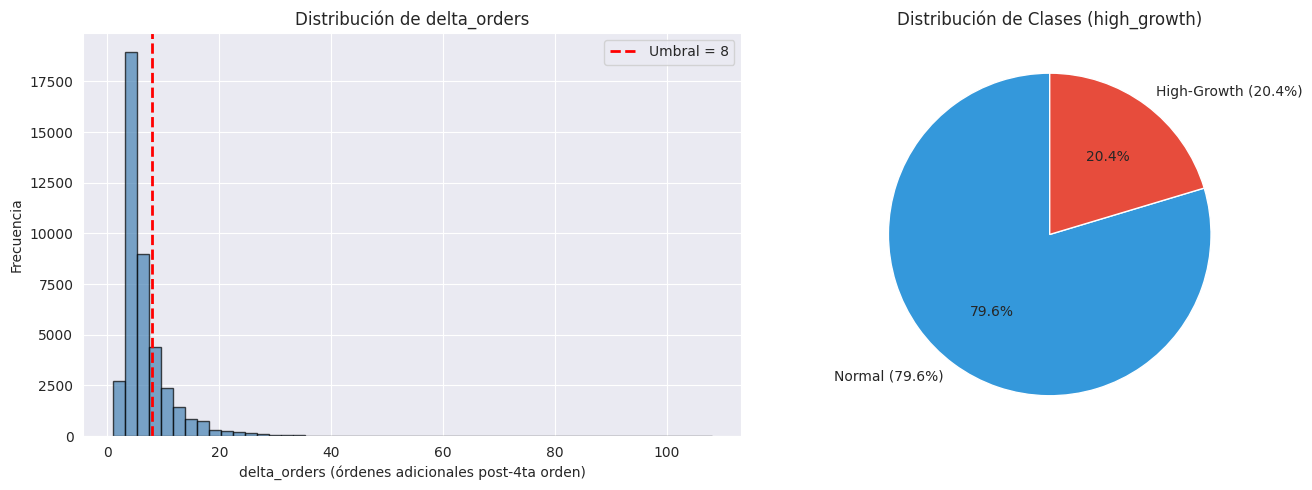


💡 Nota: El desbalance de clases (~80/20) es manejable y típico en problemas de targeting.


In [12]:
# Visualización de la distribución del target
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribución de delta_orders con línea de umbral
axes[0].hist(df['delta_orders'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(HIGH_GROWTH_THRESHOLD, color='red', linestyle='--', linewidth=2, 
                label=f'Umbral = {HIGH_GROWTH_THRESHOLD}')
axes[0].set_title('Distribución de delta_orders', fontsize=12)
axes[0].set_xlabel('delta_orders (órdenes adicionales post-4ta orden)')
axes[0].set_ylabel('Frecuencia')
axes[0].legend()

# Pie chart de high_growth
colors = ['#3498db', '#e74c3c']
labels = [f'Normal ({100-df["high_growth"].mean()*100:.1f}%)', 
          f'High-Growth ({df["high_growth"].mean()*100:.1f}%)']
axes[1].pie(df['high_growth'].value_counts(), labels=labels, colors=colors, 
            autopct='%1.1f%%', startangle=90)
axes[1].set_title('Distribución de Clases (high_growth)', fontsize=12)

plt.tight_layout()
plt.show()

print(f"\n💡 Nota: El desbalance de clases (~80/20) es manejable y típico en problemas de targeting.")

## 3. Selección de Features "Estrella" (10-15 features interpretables)

### Criterios de selección:
1. **Interpretabilidad**: Debe poder explicarse en lenguaje de negocio
2. **No redundancia**: Evitar features altamente correlacionados entre sí
3. **Poder predictivo**: Priorizar features identificados como importantes en el EDA
4. **Sin data leakage**: No usar información que no estaría disponible al momento de la predicción

In [13]:
# =============================================================================
# SELECCIÓN DE FEATURES "ESTRELLA"
# =============================================================================
# Seleccionamos 10-15 features que son:
# - Interpretables para el equipo de negocio
# - Predictivos según el EDA
# - Sin redundancia ni data leakage

print("⭐ SELECCIÓN DE FEATURES ESTRELLA\n")
print("="*70)

# -----------------------------------------------------------------------------
# GRUPO 1: VELOCIDAD DE ADOPCIÓN (Feature más predictivo según EDA)
# -----------------------------------------------------------------------------
print("\n📊 GRUPO 1: VELOCIDAD DE ADOPCIÓN")
print("   Justificación: Usuarios que llegan rápido a su 4ta orden crecen 2.3x más")
velocity_features = [
    'efo_to_four',  # Días desde 1ra hasta 4ta orden (CLAVE: correlación -0.201 con crecimiento)
]
for f in velocity_features:
    print(f"   ✓ {f}")

# -----------------------------------------------------------------------------
# GRUPO 2: RECENCIA Y ANTIGÜEDAD
# -----------------------------------------------------------------------------
print("\n📊 GRUPO 2: RECENCIA Y ANTIGÜEDAD")
print("   Justificación: Recencia tiene impacto de 7x entre Activos y Perdidos")
recency_features = [
    'categoria_recencia',  # Categoría de recencia (Activo, Semi-activo, Tibio, Frío, Perdido)
    'days_since_first_order',  # Antigüedad del usuario (días en la plataforma)
]
for f in recency_features:
    print(f"   ✓ {f}")

# -----------------------------------------------------------------------------
# GRUPO 3: DIVERSIDAD (Normalizados, no conteos crudos)
# -----------------------------------------------------------------------------
print("\n📊 GRUPO 3: DIVERSIDAD (normalizados)")
print("   Justificación: Capturan exploración sin correlación con volumen")
diversity_features = [
    'categories_per_order',  # Categorías por orden (normalizado)
    'shops_per_order',  # Tiendas por orden (normalizado)
    'category_diversity',  # Índice Shannon de categorías
    'shop_diversity',  # Índice Shannon de tiendas
]
for f in diversity_features:
    print(f"   ✓ {f}")

# -----------------------------------------------------------------------------
# GRUPO 4: CONCENTRACIÓN Y LEALTAD
# -----------------------------------------------------------------------------
print("\n📊 GRUPO 4: CONCENTRACIÓN Y LEALTAD")
print("   Justificación: Miden fidelidad a categorías/marcas favoritas")
loyalty_features = [
    'dominant_category_ratio',  # % órdenes en categoría favorita
    'brand001_ratio',  # % órdenes de marca líder (40% del mercado)
]
for f in loyalty_features:
    print(f"   ✓ {f}")

# -----------------------------------------------------------------------------
# GRUPO 5: FEATURES BINARIOS DE NEGOCIO
# -----------------------------------------------------------------------------
print("\n📊 GRUPO 5: FEATURES BINARIOS DE NEGOCIO")
print("   Justificación: Fáciles de explicar a stakeholders")
binary_features = [
    'is_multi_category',  # ¿Compra en 3+ categorías?
    'is_multi_shop',  # ¿Compra en 5+ tiendas?
]
for f in binary_features:
    print(f"   ✓ {f}")

# -----------------------------------------------------------------------------
# GRUPO 6: SEGMENTACIÓN Y GEOGRAFÍA
# -----------------------------------------------------------------------------
print("\n📊 GRUPO 6: SEGMENTACIÓN Y GEOGRAFÍA")
print("   Justificación: r_segment002 tiene mejor performance; hay diferencias por ciudad")
segment_features = [
    'r_segment',  # Segmentación de otra línea de negocio (002 es mejor)
    'city_token',  # Ciudad tokenizada
]
for f in segment_features:
    print(f"   ✓ {f}")

# -----------------------------------------------------------------------------
# GRUPO 7: AFINIDAD PRINCIPAL
# -----------------------------------------------------------------------------
print("\n📊 GRUPO 7: AFINIDAD PRINCIPAL")
print("   Justificación: Permite personalizar incentivos por categoría")
affinity_features = [
    'dominant_category',  # Categoría preferida del usuario
]
for f in affinity_features:
    print(f"   ✓ {f}")

# CONSOLIDAR LISTA FINAL
NUMERIC_FEATURES = velocity_features + ['days_since_first_order'] + diversity_features + loyalty_features
CATEGORICAL_FEATURES = ['categoria_recencia'] + segment_features + affinity_features
BINARY_FEATURES = binary_features  # Se tratan como numéricos (ya son 0/1)

ALL_FEATURES = NUMERIC_FEATURES + BINARY_FEATURES + CATEGORICAL_FEATURES

print("\n" + "="*70)
print(f"📋 RESUMEN: {len(ALL_FEATURES)} features estrella seleccionados")
print(f"   - Numéricos: {len(NUMERIC_FEATURES)}")
print(f"   - Binarios: {len(BINARY_FEATURES)}")
print(f"   - Categóricos: {len(CATEGORICAL_FEATURES)}")
print("="*70)

⭐ SELECCIÓN DE FEATURES ESTRELLA


📊 GRUPO 1: VELOCIDAD DE ADOPCIÓN
   Justificación: Usuarios que llegan rápido a su 4ta orden crecen 2.3x más
   ✓ efo_to_four

📊 GRUPO 2: RECENCIA Y ANTIGÜEDAD
   Justificación: Recencia tiene impacto de 7x entre Activos y Perdidos
   ✓ categoria_recencia
   ✓ days_since_first_order

📊 GRUPO 3: DIVERSIDAD (normalizados)
   Justificación: Capturan exploración sin correlación con volumen
   ✓ categories_per_order
   ✓ shops_per_order
   ✓ category_diversity
   ✓ shop_diversity

📊 GRUPO 4: CONCENTRACIÓN Y LEALTAD
   Justificación: Miden fidelidad a categorías/marcas favoritas
   ✓ dominant_category_ratio
   ✓ brand001_ratio

📊 GRUPO 5: FEATURES BINARIOS DE NEGOCIO
   Justificación: Fáciles de explicar a stakeholders
   ✓ is_multi_category
   ✓ is_multi_shop

📊 GRUPO 6: SEGMENTACIÓN Y GEOGRAFÍA
   Justificación: r_segment002 tiene mejor performance; hay diferencias por ciudad
   ✓ r_segment
   ✓ city_token

📊 GRUPO 7: AFINIDAD PRINCIPAL
   Justificación: 

🔍 Verificando correlaciones entre features numéricos...

⚠️ Pares con alta correlación (|r| > 0.7):
   categories_per_order ↔ shops_per_order: r = 0.751
   category_diversity ↔ shop_diversity: r = 0.808
   category_diversity ↔ dominant_category_ratio: r = -0.924
   category_diversity ↔ is_multi_category: r = 0.782
   shop_diversity ↔ is_multi_shop: r = 0.756
   dominant_category_ratio ↔ is_multi_category: r = -0.717

   → Considerar eliminar uno de cada par si causan multicolinealidad


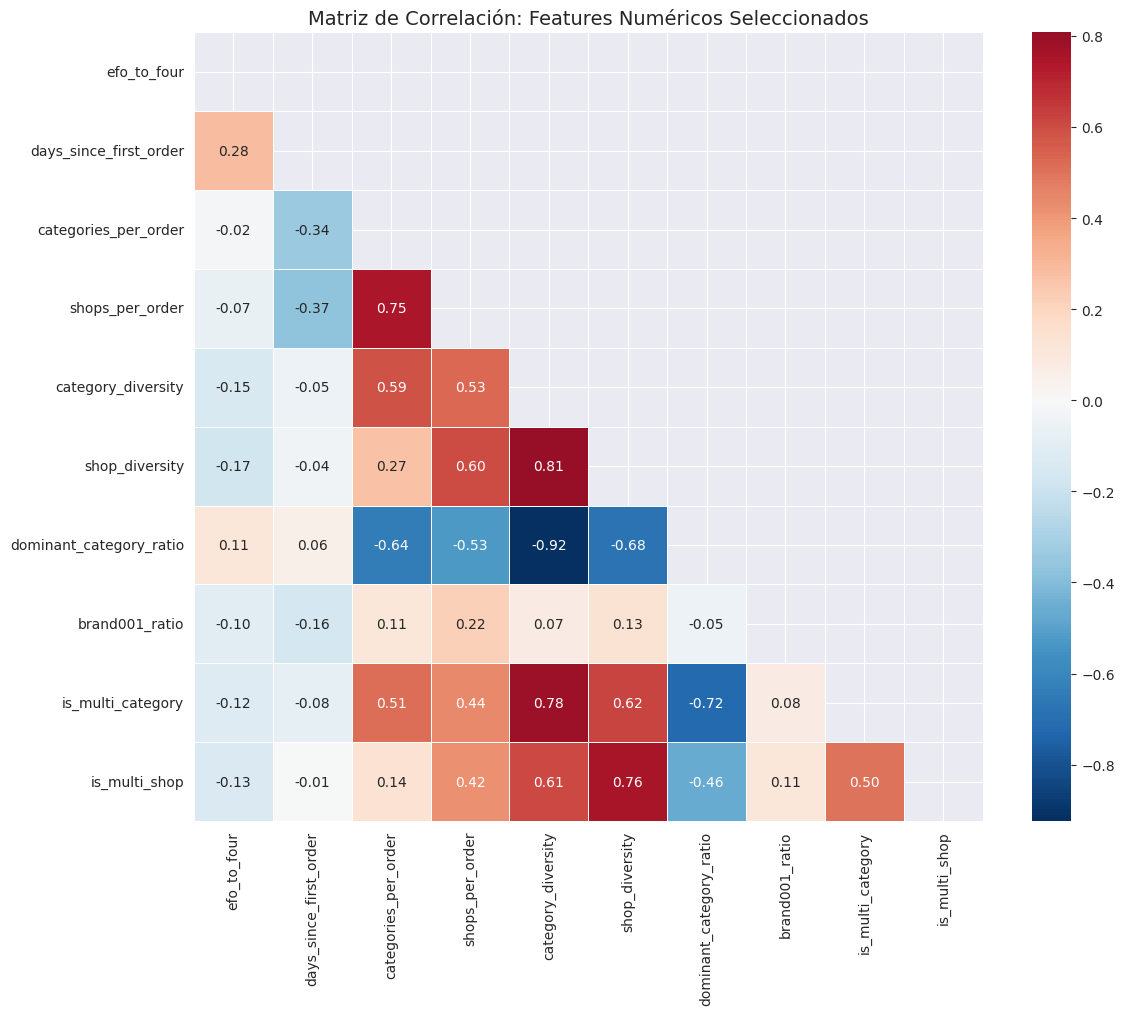

In [14]:
# Verificar correlaciones entre features numéricos para detectar redundancia
print("🔍 Verificando correlaciones entre features numéricos...\n")

numeric_for_corr = NUMERIC_FEATURES + BINARY_FEATURES
corr_matrix = df[numeric_for_corr].corr()

# Encontrar pares altamente correlacionados (|r| > 0.7)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append((
                corr_matrix.columns[i], 
                corr_matrix.columns[j], 
                corr_matrix.iloc[i, j]
            ))

if high_corr_pairs:
    print("⚠️ Pares con alta correlación (|r| > 0.7):")
    for f1, f2, r in high_corr_pairs:
        print(f"   {f1} ↔ {f2}: r = {r:.3f}")
    print("\n   → Considerar eliminar uno de cada par si causan multicolinealidad")
else:
    print("✅ No hay pares con correlación > 0.7 entre features seleccionados")

# Heatmap de correlaciones
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, square=True, linewidths=0.5)
plt.title('Matriz de Correlación: Features Numéricos Seleccionados', fontsize=14)
plt.tight_layout()
plt.show()

## 4. Preparación Final del Dataset

In [15]:
# =============================================================================
# PREPARACIÓN DEL DATASET PARA MODELADO
# =============================================================================

print("🔧 Preparando dataset final para modelado...\n")

# Crear dataset con solo las columnas necesarias
columns_for_model = ALL_FEATURES + ['high_growth', 'delta_orders', 'uid']
df_model = df[columns_for_model].copy()

print(f"📊 Dataset para modelado: {df_model.shape[0]:,} filas × {df_model.shape[1]} columnas")
print(f"\n📋 Columnas incluidas:")
for i, col in enumerate(df_model.columns, 1):
    print(f"   {i:2d}. {col}")

# Verificar valores faltantes
missing = df_model.isnull().sum()
if missing.sum() > 0:
    print(f"\n⚠️ Valores faltantes detectados:")
    print(missing[missing > 0])
else:
    print(f"\n✅ No hay valores faltantes")

df_model.head()

🔧 Preparando dataset final para modelado...

📊 Dataset para modelado: 41,667 filas × 17 columnas

📋 Columnas incluidas:
    1. efo_to_four
    2. days_since_first_order
    3. categories_per_order
    4. shops_per_order
    5. category_diversity
    6. shop_diversity
    7. dominant_category_ratio
    8. brand001_ratio
    9. is_multi_category
   10. is_multi_shop
   11. categoria_recencia
   12. r_segment
   13. city_token
   14. dominant_category
   15. high_growth
   16. delta_orders
   17. uid

✅ No hay valores faltantes


,efo_to_four,days_since_first_order,categories_per_order,shops_per_order,category_diversity,shop_diversity,dominant_category_ratio,brand001_ratio,is_multi_category,is_multi_shop,categoria_recencia,r_segment,city_token,dominant_category,high_growth,delta_orders,uid
0,8,79,0.800000,1.000000,1.332179,1.609438,0.400000,0.600000,1,1,Frío (31–90d),r_segment001,city002,main_category007,0,5,492892698476209
1,4,41,0.555556,0.777778,1.303092,1.831020,0.555556,0.000000,1,1,Tibio (15–30d),r_segment002,city001,main_category021,1,9,492892701117693
2,2,76,0.777778,0.888889,1.831020,2.043192,0.333333,0.111111,1,1,Frío (31–90d),r_segment001,city001,main_category008,1,9,492892701156786
3,9,51,0.750000,1.000000,1.039721,1.386294,0.500000,0.000000,1,0,Frío (31–90d),r_segment002,city006,main_category008,0,4,492892701766066
4,6,86,0.285714,0.821429,1.871160,3.065965,0.285714,0.357143,1,1,Tibio (15–30d),r_segment001,city006,main_category008,1,28,492892702909369


### 4.1 Encoding de Variables Categóricas

In [16]:
# =============================================================================
# ONE-HOT ENCODING DE VARIABLES CATEGÓRICAS
# =============================================================================
# Usamos drop_first=True para evitar multicolinealidad perfecta

print("🔧 Aplicando One-Hot Encoding a variables categóricas...\n")

# Variables categóricas a encodear
print(f"📋 Variables categóricas:")
for cat in CATEGORICAL_FEATURES:
    n_unique = df_model[cat].nunique()
    print(f"   - {cat}: {n_unique} valores únicos")

# Aplicar one-hot encoding con pandas (más simple y controlado)
df_encoded = pd.get_dummies(df_model, columns=CATEGORICAL_FEATURES, drop_first=True, dtype=int)

# Contar nuevas columnas creadas
new_cols = [col for col in df_encoded.columns if col not in df_model.columns]
original_cat_cols = len(CATEGORICAL_FEATURES)
encoded_cols = len(new_cols)

print(f"\n✅ Encoding completado:")
print(f"   - Variables categóricas originales: {original_cat_cols}")
print(f"   - Columnas después de one-hot: {encoded_cols}")
print(f"   - Total de features: {len(df_encoded.columns) - 3} (sin uid, high_growth, delta_orders)")

🔧 Aplicando One-Hot Encoding a variables categóricas...

📋 Variables categóricas:
   - categoria_recencia: 5 valores únicos
   - r_segment: 3 valores únicos
   - city_token: 7 valores únicos
   - dominant_category: 28 valores únicos

✅ Encoding completado:
   - Variables categóricas originales: 4
   - Columnas después de one-hot: 39
   - Total de features: 49 (sin uid, high_growth, delta_orders)


### 4.2 Scaling de Variables Numéricas

In [17]:
# =============================================================================
# STANDARD SCALING DE VARIABLES NUMÉRICAS
# =============================================================================
# Estandarizamos a media=0 y std=1 para:
# - Mejor convergencia en algunos algoritmos
# - Comparabilidad de coeficientes
# Nota: Los features binarios (0/1) se mantienen sin escalar

print("🔧 Aplicando StandardScaler a variables numéricas...\n")

# Identificar columnas a escalar (numéricas continuas, no binarias ni encoded)
cols_to_scale = NUMERIC_FEATURES.copy()  # Solo las numéricas continuas
print(f"📋 Variables a escalar: {cols_to_scale}")

# Crear scaler
scaler = StandardScaler()

# Aplicar scaling
df_encoded[cols_to_scale] = scaler.fit_transform(df_encoded[cols_to_scale])

# Verificar
print(f"\n✅ Scaling completado")
print(f"\n📊 Verificación (media ≈ 0, std ≈ 1):")
print(df_encoded[cols_to_scale[:3]].describe().loc[['mean', 'std']])

🔧 Aplicando StandardScaler a variables numéricas...

📋 Variables a escalar: ['efo_to_four', 'days_since_first_order', 'categories_per_order', 'shops_per_order', 'category_diversity', 'shop_diversity', 'dominant_category_ratio', 'brand001_ratio']

✅ Scaling completado

📊 Verificación (media ≈ 0, std ≈ 1):
       efo_to_four  days_since_first_order  categories_per_order
mean  9.822464e-17            1.145954e-16         -1.364231e-17
std   1.000012e+00            1.000012e+00          1.000012e+00


## 5. Split de Datos: Train / Validation / Test

In [18]:
# =============================================================================
# SPLIT ESTRATIFICADO DE DATOS
# =============================================================================
# - Train (60%): Entrenar modelos
# - Validation (20%): Optimizar hiperparámetros y seleccionar modelo
# - Test (20%): Evaluación final (SE USA UNA SOLA VEZ)
#
# Usamos split estratificado por high_growth para preservar la proporción de clases

print("🔧 Realizando split estratificado de datos...\n")

# Separar features y targets
feature_cols = [col for col in df_encoded.columns if col not in ['uid', 'high_growth', 'delta_orders']]
X = df_encoded[feature_cols]
y = df_encoded['high_growth']
y_regression = df_encoded['delta_orders']
uids = df_encoded['uid']

print(f"📊 Features totales: {len(feature_cols)}")
print(f"📊 Observaciones: {len(X):,}")

# Primer split: Train (60%) vs Temp (40%)
X_train, X_temp, y_train, y_temp, y_reg_train, y_reg_temp, uid_train, uid_temp = train_test_split(
    X, y, y_regression, uids,
    test_size=(VAL_SIZE + TEST_SIZE),
    stratify=y,
    random_state=RANDOM_SEED
)

# Segundo split: Validation (50% de temp = 20% total) vs Test (50% de temp = 20% total)
X_val, X_test, y_val, y_test, y_reg_val, y_reg_test, uid_val, uid_test = train_test_split(
    X_temp, y_temp, y_reg_temp, uid_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=RANDOM_SEED
)

print(f"\n✅ Split completado:")
print(f"   - Train: {X_train.shape[0]:,} usuarios ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"   - Validation: {X_val.shape[0]:,} usuarios ({X_val.shape[0]/len(df)*100:.1f}%)")
print(f"   - Test: {X_test.shape[0]:,} usuarios ({X_test.shape[0]/len(df)*100:.1f}%)")

# Verificar preservación de distribución
print(f"\n📊 Verificación de estratificación (% high_growth):")
print(f"   - Original: {y.mean()*100:.2f}%")
print(f"   - Train: {y_train.mean()*100:.2f}%")
print(f"   - Validation: {y_val.mean()*100:.2f}%")
print(f"   - Test: {y_test.mean()*100:.2f}%")
print(f"   ✅ Distribución preservada correctamente")

🔧 Realizando split estratificado de datos...

📊 Features totales: 49
📊 Observaciones: 41,667

✅ Split completado:
   - Train: 25,000 usuarios (60.0%)
   - Validation: 8,333 usuarios (20.0%)
   - Test: 8,334 usuarios (20.0%)

📊 Verificación de estratificación (% high_growth):
   - Original: 20.36%
   - Train: 20.36%
   - Validation: 20.35%
   - Test: 20.36%
   ✅ Distribución preservada correctamente


In [19]:
# Crear DataFrames finales para guardar
train_df = X_train.copy()
train_df['high_growth'] = y_train.values
train_df['delta_orders'] = y_reg_train.values
train_df['uid'] = uid_train.values

val_df = X_val.copy()
val_df['high_growth'] = y_val.values
val_df['delta_orders'] = y_reg_val.values
val_df['uid'] = uid_val.values

test_df = X_test.copy()
test_df['high_growth'] = y_test.values
test_df['delta_orders'] = y_reg_test.values
test_df['uid'] = uid_test.values

print(f"✅ DataFrames finales creados")
print(f"   - Train: {train_df.shape}")
print(f"   - Validation: {val_df.shape}")
print(f"   - Test: {test_df.shape}")

✅ DataFrames finales creados
   - Train: (25000, 52)
   - Validation: (8333, 52)
   - Test: (8334, 52)


## 6. Guardar Datasets y Artefactos

In [20]:
# =============================================================================
# GUARDAR DATASETS PROCESADOS
# =============================================================================

print("💾 Guardando datasets procesados...\n")

# Crear directorios
output_dir = '../data/processed'
models_dir = '../models'
os.makedirs(output_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

# Guardar CSVs
train_df.to_csv(f'{output_dir}/train.csv', index=False)
print(f"  ✓ Train guardado: {output_dir}/train.csv")

val_df.to_csv(f'{output_dir}/val.csv', index=False)
print(f"  ✓ Validation guardado: {output_dir}/val.csv")

test_df.to_csv(f'{output_dir}/test.csv', index=False)
print(f"  ✓ Test guardado: {output_dir}/test.csv")

# Guardar pipeline de transformación
pipeline_dict = {
    'scaler': scaler,
    'numeric_features': NUMERIC_FEATURES,
    'categorical_features': CATEGORICAL_FEATURES,
    'binary_features': BINARY_FEATURES,
    'feature_cols': feature_cols,
    'high_growth_threshold': HIGH_GROWTH_THRESHOLD,
    'multi_category_threshold': MULTI_CATEGORY_THRESHOLD,
    'multi_shop_threshold': MULTI_SHOP_THRESHOLD,
}

with open(f'{models_dir}/feature_engineering_pipeline.pkl', 'wb') as f:
    pickle.dump(pipeline_dict, f)
print(f"  ✓ Pipeline guardado: {models_dir}/feature_engineering_pipeline.pkl")

print("\n✅ Todos los artefactos guardados exitosamente")

💾 Guardando datasets procesados...

  ✓ Train guardado: ../data/processed/train.csv
  ✓ Validation guardado: ../data/processed/val.csv
  ✓ Test guardado: ../data/processed/test.csv
  ✓ Pipeline guardado: ../models/feature_engineering_pipeline.pkl

✅ Todos los artefactos guardados exitosamente


## 7. Resumen Final

In [21]:
print("="*80)
print("RESUMEN FINAL - PREPARACIÓN DE DATOS (VERSIÓN MEJORADA)")
print("="*80)

print(f"\n📊 DATASET ORIGINAL:")
print(f"   - Tamaño: {df.shape[0]:,} usuarios × {df.shape[1]} variables")

print(f"\n🎯 VARIABLE OBJETIVO:")
print(f"   - high_growth = 1 si delta_orders > {HIGH_GROWTH_THRESHOLD}")
print(f"   - Umbral corresponde al percentil {percentil_real:.1f}%")
print(f"   - {df['high_growth'].sum():,} usuarios high-growth ({df['high_growth'].mean()*100:.1f}%)")

print(f"\n⭐ FEATURES ESTRELLA SELECCIONADOS ({len(ALL_FEATURES)} pre-encoding):")
print(f"\n   VELOCIDAD:")
print(f"   - efo_to_four: días hasta 4ta orden (predictor clave, -0.201 corr con crecimiento)")
print(f"\n   RECENCIA:")
print(f"   - categoria_recencia: estado de actividad (impacto 7x entre Activo y Perdido)")
print(f"   - days_since_first_order: antigüedad del usuario")
print(f"\n   DIVERSIDAD (normalizados):")
print(f"   - categories_per_order: exploración de categorías por orden")
print(f"   - shops_per_order: distribución de tiendas por orden")
print(f"   - category_diversity: índice Shannon de categorías")
print(f"   - shop_diversity: índice Shannon de tiendas")
print(f"\n   CONCENTRACIÓN:")
print(f"   - dominant_category_ratio: fidelidad a categoría favorita")
print(f"   - brand001_ratio: afinidad con marca líder")
print(f"\n   NEGOCIO (binarios):")
print(f"   - is_multi_category: ¿compra en 3+ categorías?")
print(f"   - is_multi_shop: ¿compra en 5+ tiendas?")
print(f"\n   SEGMENTACIÓN:")
print(f"   - r_segment: segmento de otra línea de negocio")
print(f"   - city_token: ciudad")
print(f"   - dominant_category: categoría preferida")

print(f"\n📊 FEATURES DESPUÉS DE ENCODING: {len(feature_cols)}")

print(f"\n📂 DATASETS GENERADOS:")
print(f"   - Train: {train_df.shape[0]:,} usuarios ({TRAIN_SIZE*100:.0f}%)")
print(f"   - Validation: {val_df.shape[0]:,} usuarios ({VAL_SIZE*100:.0f}%)")
print(f"   - Test: {test_df.shape[0]:,} usuarios ({TEST_SIZE*100:.0f}%)")

print(f"\n🚀 PRÓXIMO PASO:")
print(f"   Notebook 02: Entrenamiento de Modelos de Clasificación")
print(f"   - Cargar datasets desde data/processed/")
print(f"   - Entrenar Random Forest y XGBoost")
print(f"   - Evaluar con AUC-ROC, F1, Precision@20%")
print(f"   - Seleccionar mejor modelo")

print(f"\n" + "="*80)
print(f"✅ PREPARACIÓN DE DATOS COMPLETADA EXITOSAMENTE")
print("="*80)

RESUMEN FINAL - PREPARACIÓN DE DATOS (VERSIÓN MEJORADA)

📊 DATASET ORIGINAL:
   - Tamaño: 41,667 usuarios × 30 variables

🎯 VARIABLE OBJETIVO:
   - high_growth = 1 si delta_orders > 8
   - Umbral corresponde al percentil 79.6%
   - 8,483 usuarios high-growth (20.4%)

⭐ FEATURES ESTRELLA SELECCIONADOS (14 pre-encoding):

   VELOCIDAD:
   - efo_to_four: días hasta 4ta orden (predictor clave, -0.201 corr con crecimiento)

   RECENCIA:
   - categoria_recencia: estado de actividad (impacto 7x entre Activo y Perdido)
   - days_since_first_order: antigüedad del usuario

   DIVERSIDAD (normalizados):
   - categories_per_order: exploración de categorías por orden
   - shops_per_order: distribución de tiendas por orden
   - category_diversity: índice Shannon de categorías
   - shop_diversity: índice Shannon de tiendas

   CONCENTRACIÓN:
   - dominant_category_ratio: fidelidad a categoría favorita
   - brand001_ratio: afinidad con marca líder

   NEGOCIO (binarios):
   - is_multi_category: ¿compr